# Descriptive Analysis DataOrtho

## Detalhes pré - resampling de MRI
**TO DO**
- ~~Análise descritiva para pixel spacing, rows e columns~~
- Tratar análise a sequências em extensão com e sem contração, em flexão com e sem contração
    15º -> flexão
    sem 15º -> extensão
    (repouso -> sem contração, com contração)
- Interpolation study e librarias de python: https://www.kaggle.com/code/del=dbedcc5fb8838374/dicom-full-processing-tutorial/notebook

**Questões**
- Valores NaN em dataset dynamic
- Sequências de sagital sem tipo de weight-constrast (ver em baixo)
- Isotropic voxels? 

**Correlação entre Pixel e Spatial Dimensions (depth determination and voxel size)**
- 'Pixel spacing' define o tamanho de cada voxel no plano 2D (x and y dimensions)
- 'Slice Thickness' e 'Spacing between Slices' definem o tamanho do voxel na coordenada z, com o total depth do volume a ser aproximadamente 'Num slices' x 'Slice Thickness'


In [1]:
import os
import pydicom
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns

In [2]:
#base paths
base_path = "D:/DataOrtho"
excel_paths = ['D:/DataOrtho/DATASET_AXIAL/dataset_axial.xlsx','D:/DataOrtho/DATASET_DYNAMIC/dataset_dynamic.xlsx','D:/DataOrtho/DATASET_SAGITTAL/dataset_sagittal.xlsx']

Só a testar alguns dados hard coded

In [3]:
path ='D:/DataOrtho/DATASET_DYNAMIC/1/LEFT/t1_vibe_tra_ext_com_contracao_18/IM-0009-0001.dcm'
path2 ='D:/DataOrtho/DATASET_AXIAL/24/LEFT/pd_tse_fs_tra_13/IM-0007-0001.dcm'
path3 = 'D:/DataOrtho/DATASET_DYNAMIC/30/LEFT/eTHRIVE_BH_15graus_contracao_1701/IM-0031-0001-0002.dcm'


dc = pydicom.dcmread(path)
dc2 = pydicom.dcmread(path2)

print(dc2.get('SpacingBetweenSlices'))
print(dc2.get('SliceThickness'))
print(dc2.get('PixelSpacing'))
print(dc2.get('Rows'))
print(dc2.get('Columns'))


3.9
3
[0.52499997615814, 0.52499997615814]
320
320


### 1. Dataframe construction from CSV stored data

### The dataframe has the following columns:
- **Subset**: The type of subset (Axial, Dynamic, or Sagittal).
- **Individual**: Identifier of the individual.
- **Knee**: Which knee (Left or Right).
- **Sequence**: Name of the MRI sequence.
- **Num_Slices**: Number of slices in the sequence.
- **Slice_Thickness**: Thickness of each slice in the sequence.
- **Spacing_between_Slices**: Space between the slices in the sequence.
- **Pixel_Spacing**: The spacing between pixels in the X and Y directions.

Old

In [19]:
metadata_df2 = pd.read_csv("metadata/before_validation_pixelData/metadata_df.csv")

New validated

In [4]:
metadata_dfVal = pd.read_csv('metadata/after_validation_pixelData/validated_metadata.csv')

### extract_metadata method
1. **Accumulate metadata across DICOM slices**: Instead of overwriting the metadata with every new DICOM slice, we should accumulate it. So if one slice provides SliceThickness and another provides SpacingBetweenSlices, we should combine the information.

2. **Break only when all metadata is acquired or all slices are checked**: Currently, the loop breaks as soon as one slice provides all the required metadata. However, since metadata can be scattered across slices, we should iterate through all slices until we've gathered all required metadata or we've checked all slices.

3. **Append to the data even if some metadata is missing**: If, after checking all slices of a sequence, some metadata is still missing, we should still append the sequence to the dataframe, with NaN values for the missing metadata.

In [27]:
# try to read a DICOM file. Return False if there's an error, method for obtaining correct num_slices 
def validate_dicom_image_data(file_path):
    try:
        dc = pydicom.dcmread(file_path)
        if 'PixelData' in dc:
            return True
        else:
            return False
    except:
        return False

In [35]:
def extract_metadata(base_path):
    data = []
    total_sequences = 0  # Count of all sequences processed
    added_sequences = 0
    for subset in os.listdir(base_path):
        subset_path = os.path.join(base_path, subset)
        if os.path.isdir(subset_path):
            for individual in os.listdir(subset_path):
                individual_path = os.path.join(subset_path, individual)
                if os.path.isdir(individual_path):
                    for knee in os.listdir(individual_path):
                        knee_path = os.path.join(individual_path, knee)
                        for sequence in os.listdir(knee_path):
                            total_sequences += 1
                            sequence_path = os.path.join(knee_path, sequence)
                            # ESTE VALOR NÃO SIGNIFICA O NÚMERO DE Slices
                            num_slices = len([f for f in os.listdir(sequence_path) if f.endswith('.dcm') and validate_dicom_image_data(os.path.join(sequence_path, f))])
                            
                            sliceThickness = float('nan')
                            spacingBetweenSlices = float('nan')
                            pixelSpacing = [float('nan'), float('nan')]
                            rows = float('nan')
                            columns = float('nan')
                            for i, dicom in enumerate(os.listdir(sequence_path)):
                                try:
                                    current_slice = pydicom.dcmread(os.path.join(sequence_path, dicom))
                                    sliceThickness = current_slice.get("SliceThickness", sliceThickness)
                                    spacingBetweenSlices = current_slice.get("SpacingBetweenSlices", spacingBetweenSlices)
                                    pixelSpacing = current_slice.get("PixelSpacing", pixelSpacing)
                                    rows = current_slice.get('Rows',rows)
                                    columns = current_slice.get('Columns',columns)
                                    
                                    if not (np.isnan(sliceThickness) or np.isnan(spacingBetweenSlices) or np.isnan(pixelSpacing[0]) or np.isnan(pixelSpacing[1])):
                                        break
                                except Exception as e:
                                    print(f'Error reading the file in {sequence_path}: {e}')
                                    continue

                            data.append({
                                'Subset': subset,
                                'Individual': int(individual),
                                'Knee': knee,
                                'Sequence': sequence,
                                'Num_Slices': num_slices,
                                'Slice_Thickness': sliceThickness,
                                'Spacing_between_Slices': spacingBetweenSlices,
                                'Pixel_Spacing': pixelSpacing,
                                'Rows': rows,
                                'Columns':columns
                            })
                            added_sequences += 1

    print(f"Total sequences processed: {total_sequences}")
    print(f"Sequences added to DataFrame: {added_sequences}")
    return pd.DataFrame(data)


In [36]:
# with new version of extract_metadata
metadata_dfValta = extract_metadata(base_path)

Error reading the file in D:/DataOrtho\DATASET_AXIAL\28\LEFT\DP_SPAIR_TRA_1301: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
Error reading the file in D:/DataOrtho\DATASET_AXIAL\29\LEFT\DP_SPAIR_TRA_401: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
Error reading the file in D:/DataOrtho\DATASET_AXIAL\29\RIGHT\DP_SPAIR_TRA_501: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
Error reading the file in D:/DataOrtho\DATASET_AXIAL\30\LEFT\DP_SPAIR_TRA_401: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
Error reading the file in D:/DataOrtho\DATASET_AXIAL\31\LEFT\DP_SPAIR_TRA_501: File is missing DICOM File Meta Information header or the 'DICM' prefix

In [15]:
metadata_df2 = extract_metadata(base_path)

Error reading the file in D:/DataOrtho\DATASET_AXIAL\28\LEFT\DP_SPAIR_TRA_1301: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
Error reading the file in D:/DataOrtho\DATASET_AXIAL\29\LEFT\DP_SPAIR_TRA_401: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
Error reading the file in D:/DataOrtho\DATASET_AXIAL\29\RIGHT\DP_SPAIR_TRA_501: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
Error reading the file in D:/DataOrtho\DATASET_AXIAL\30\LEFT\DP_SPAIR_TRA_401: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
Error reading the file in D:/DataOrtho\DATASET_AXIAL\31\LEFT\DP_SPAIR_TRA_501: File is missing DICOM File Meta Information header or the 'DICM' prefix

In [4]:
print(len(metadata_dfVal))

993


In [5]:
print(len(metadata_dfVal[metadata_dfVal['Subset'] == 'DATASET_AXIAL']))
print(len(metadata_dfVal[metadata_dfVal['Subset'] == 'DATASET_SAGITTAL']))
print(len(metadata_dfVal[metadata_dfVal['Subset'] == 'DATASET_DYNAMIC']))

234
429
330


### Sorted metadata_df2

In [31]:
metadata_df2 = metadata_df2.sort_values(by=['Subset', 'Individual'], ascending=[True, True])

In [5]:
metadata_dfVal = metadata_dfVal.sort_values(by=['Subset', 'Individual'], ascending=[True, True])

### Save metadata

In [20]:
# store into csv
metadata_df2.to_csv('data/before_validation_pixelData/metadata_df.csv',index=False)

In [38]:
metadata_dfVal.to_csv('data/validated_metadata_df.csv',index=False)

In [32]:
print(metadata_df2.head())

   Unnamed: 0         Subset  Individual   Knee                 Sequence  \
0           0  DATASET_AXIAL           1   LEFT      pd_tse_fs_tra_320_3   
1           1  DATASET_AXIAL           1   LEFT             t1_tse_tra_4   
2           2  DATASET_AXIAL           1  RIGHT  pd_tse_fs_tra_320_dto_3   
3           3  DATASET_AXIAL           1  RIGHT         t1_tse_tra_dto_4   
4          34  DATASET_AXIAL           2   LEFT   pd_tse_fs_tra_FIL_1_20   

   Num_Slices  Slice_Thickness  Spacing_between_Slices  \
0          30              3.0                    3.90   
1          26              3.0                    3.90   
2          30              3.0                    3.90   
3          30              3.0                    3.90   
4          31              3.0                    4.05   

                Pixel_Spacing  Rows  Columns  Pixel_Spacing_X  \
0                  [0.5, 0.5]   320      300         0.500000   
1  [0.314453125, 0.314453125]   512      416         0.314453   

### Describing the dataframe on Number of Slices/ Slice counts

In [33]:
# stats for all subsets on Num_Slices, correct values. Total count = 993 valid sequences
print(metadata_df2['Num_Slices'].describe())

count    993.000000
mean      35.692850
std       16.179728
min       16.000000
25%       26.000000
50%       30.000000
75%       36.000000
max       91.000000
Name: Num_Slices, dtype: float64


## Distribution of 'Slice counts' by Subset

The Num_Slices column varies from 16 to 91, with a mean value of around 36.

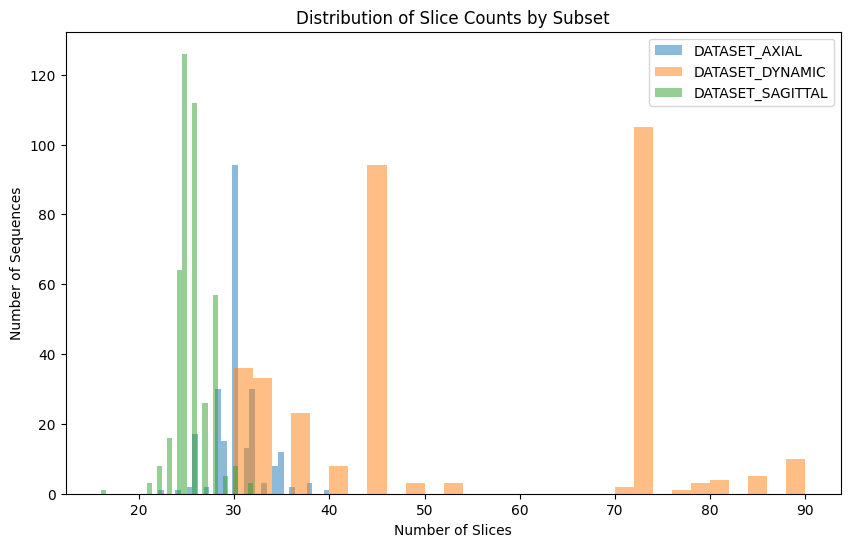

In [10]:
# plot distribution of slice counts for each subset
plt.figure(figsize=(10, 6))
for subset in metadata_dfVal['Subset'].unique():
    subset_data = metadata_dfVal[metadata_dfVal['Subset'] == subset]
    plt.hist(subset_data['Num_Slices'], bins=30, alpha=0.5, label=subset)
plt.title('Distribution of Slice Counts by Subset')
plt.xlabel('Number of Slices')
plt.ylabel('Number of Sequences')
plt.legend()
plt.show()

### Plot Average method

In [11]:
def plotAverage(average_slices,title,x_label,y_label):
    plt.figure(figsize=(10, 6))
    bars = plt.bar(average_slices.index, average_slices.values, color=['blue', 'green', 'red'])

    # add value on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center', va='bottom')

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(rotation=0)  # ensures that the subset names are horizontal on x axis
    plt.show()

### Descrition of each Subset

In [43]:
subsets_metadata = metadata_df2.groupby('Subset')


In [44]:
subsets_metadata.describe()

Individual                                                \
                      count       mean        std  min   25%   50%    75%   
Subset                                                                      
DATASET_AXIAL         234.0  42.452991  26.230571  1.0  18.0  43.0  63.75   
DATASET_DYNAMIC       330.0  41.642424  24.490418  1.0  21.0  40.0  63.00   
DATASET_SAGITTAL      429.0  42.251748  25.394863  1.0  20.0  42.0  62.00   

                       Num_Slices             ...   Rows        Columns  \
                   max      count       mean  ...    75%    max   count   
Subset                                        ...                         
DATASET_AXIAL     94.0      234.0  30.209402  ...  368.0  512.0   234.0   
DATASET_DYNAMIC   85.0      330.0  52.642424  ...  384.0  384.0   330.0   
DATASET_SAGITTAL  91.0      429.0  25.645688  ...  320.0  960.0   429.0   

                                                                            
                        mean        std    min    25%    50%    75%    max  
Subset                                                                      
DATASET_AXIAL     342.811966  53.205962  260.0  312.0  320.0  368.0  512.0  
DATASET_DYNAMIC   333.575758  36.181769  256.0  320.0  320.0  384.0  384.0  
DATASET_SAGITTAL  359.240093  97.068772  256.0  320.0  320.0  320.0  960.0  

[3 rows x 48 columns]

## Average assessment of the diferent specifications for each Subset, algorithm

### Average of 'Num_Slices' for each Subset

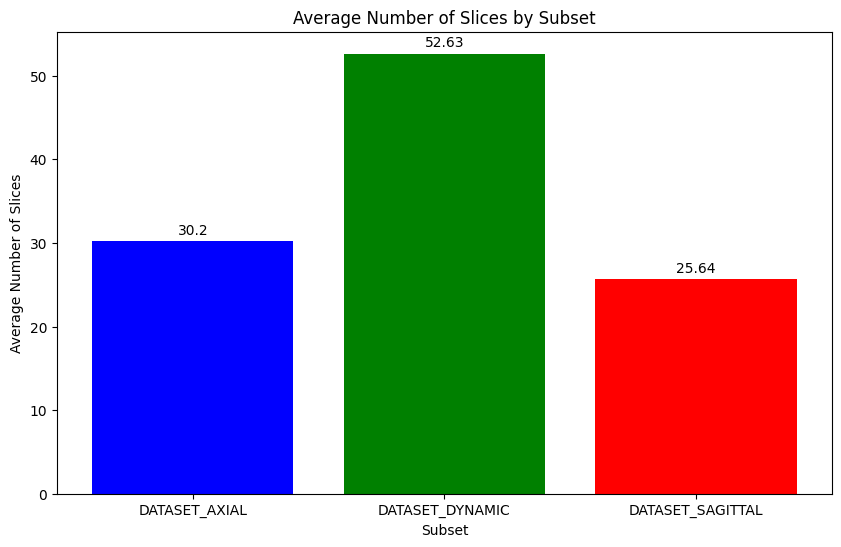

In [12]:
average_slices = metadata_dfVal.groupby('Subset')['Num_Slices'].mean()
plotAverage(average_slices,'Average Number of Slices by Subset','Subset','Average Number of Slices')


In [13]:
subset_analysis = []

subsets = metadata_dfVal['Subset'].unique()
for subset in subsets:
    subset_data = metadata_dfVal[metadata_dfVal['Subset'] == subset]
    
    # means for spec
    mean_slice_thickness = subset_data['Slice_Thickness'].mean()
    mean_spacing_between_slices = subset_data['Spacing_between_Slices'].mean()
    mean_rows = subset_data['Rows'].mean()
    mean_columns = subset_data['Columns'].mean()
    # split the pixel spacing into its two components and calculate their mean
    pixel_spacings = subset_data['Pixel_Spacing'].astype(str).str.strip("[]").str.split(",", expand=True).astype(float)
    mean_pixel_spacing_x = pixel_spacings[0].mean()
    mean_pixel_spacing_y = pixel_spacings[1].mean()
    
    subset_analysis.append({
        'Subset': subset,
        'Mean_Slice_Thickness': mean_slice_thickness,
        'Mean_Spacing_Between_Slices': mean_spacing_between_slices,
        'Mean_Pixel_Spacing_X': mean_pixel_spacing_x,
        'Mean_Pixel_Spacing_Y': mean_pixel_spacing_y,
        'Mean_Rows': mean_rows,
        'Mean_Columns': mean_columns
    })

subset_analysis_df = pd.DataFrame(subset_analysis)
print(subset_analysis_df)

             Subset  Mean_Slice_Thickness  Mean_Spacing_Between_Slices  \
0     DATASET_AXIAL              3.041026                     3.712778   
1   DATASET_DYNAMIC              3.143939                     1.500000   
2  DATASET_SAGITTAL              3.004662                     3.703147   

   Mean_Pixel_Spacing_X  Mean_Pixel_Spacing_Y   Mean_Rows  Mean_Columns  
0              0.440767              0.440767  364.547009    342.811966  
1              0.998542              0.998542  243.848485    333.575758  
2              0.414871              0.414871  358.713287    359.240093  


### Average of 'Slice_Thickness' for each Subset

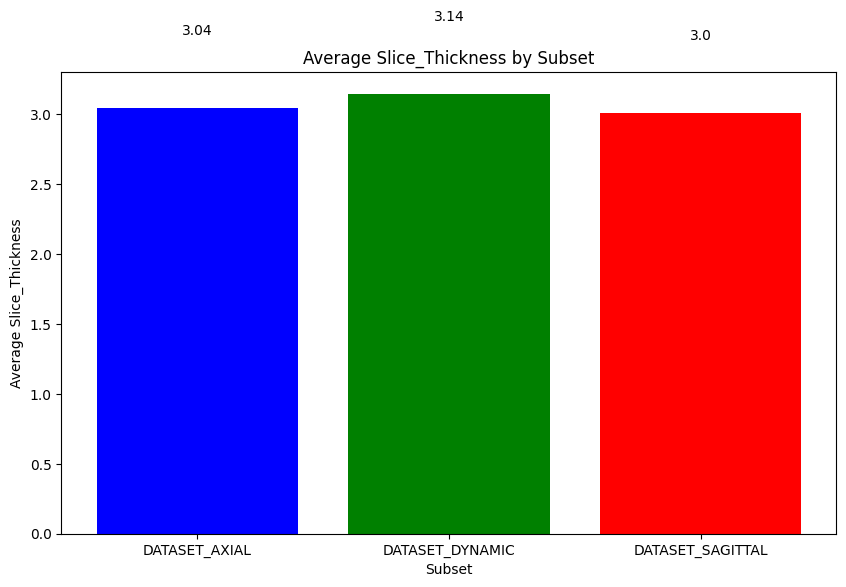

In [14]:
average_thickness = subset_analysis_df.groupby('Subset')['Mean_Slice_Thickness'].mean()
plotAverage(average_thickness,'Average Slice_Thickness by Subset','Subset','Average Slice_Thickness')

### Average of 'Spacing_Between_Slices' for each Subset

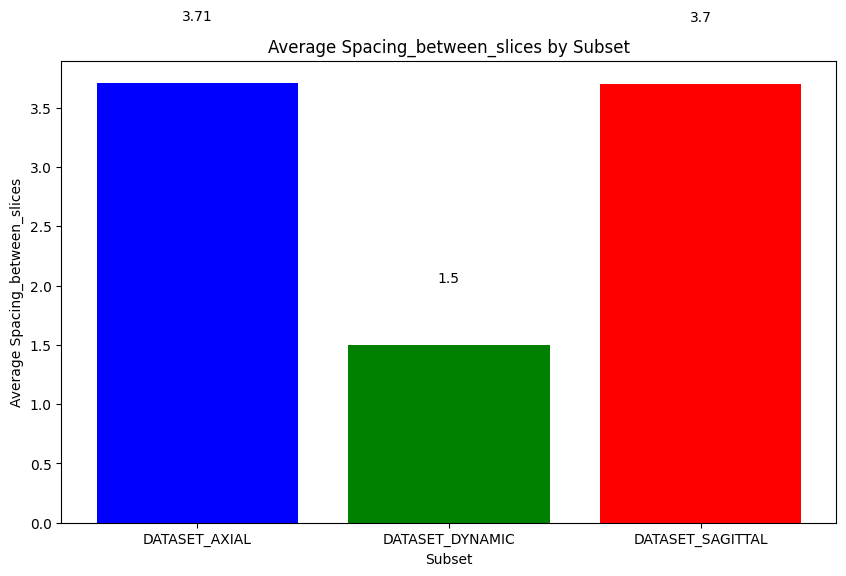

In [15]:
average_spacing = subset_analysis_df.groupby('Subset')['Mean_Spacing_Between_Slices'].mean()
plotAverage(average_spacing,'Average Spacing_between_slices by Subset','Subset','Average Spacing_between_slices')

### Mean values of 'Rows' and 'Columns' for each Subset

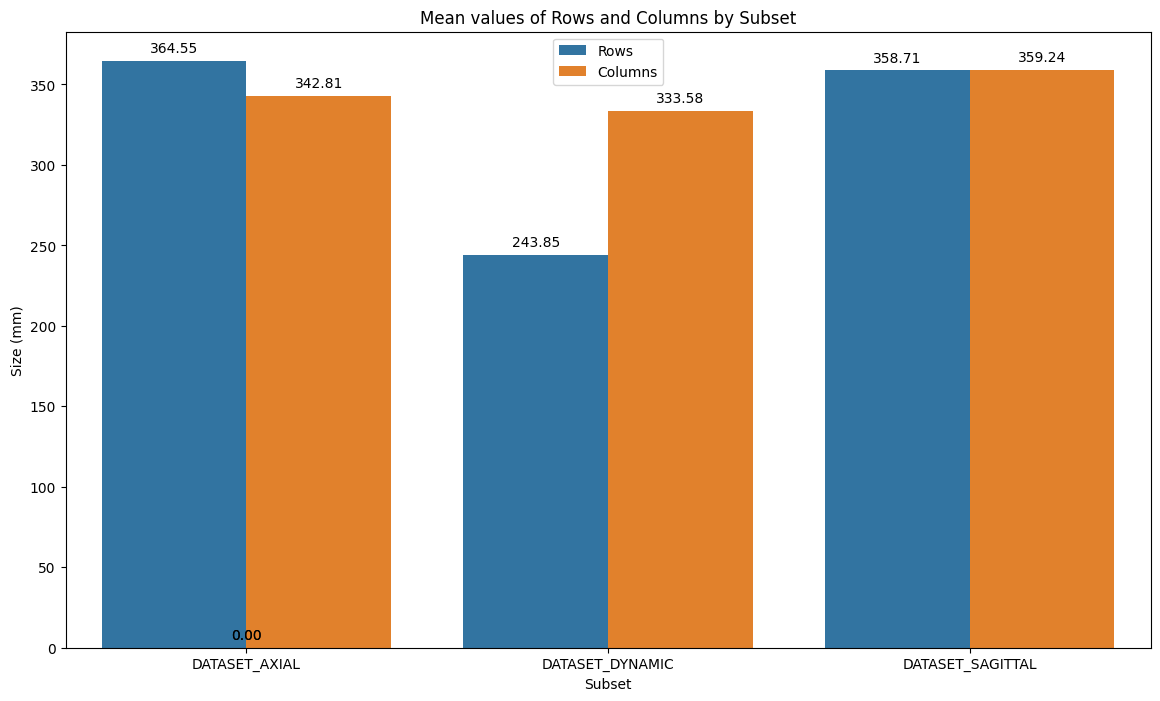

In [16]:
subset_means_ro_col = metadata_dfVal.groupby('Subset')[['Rows','Columns']].mean().reset_index()
# plot distribution of slice counts for each subset
plt.figure(figsize=(14, 8))

# id_vars argument specifies the column we want to keep 
# 
ax = sns.barplot(data=subset_means_ro_col.melt(id_vars='Subset', value_vars=['Rows', 'Columns']), 
            x='Subset', y='value', hue='variable')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')
plt.title('Mean values of Rows and Columns by Subset')
plt.xlabel('Subset')
plt.ylabel('Size (mm)')
plt.legend()
plt.show()

### Mean values of Pixel_Spacing for each Subset

In [25]:
pixel_spacings = metadata_dfVal['Pixel_Spacing'].astype(str).str.strip('[]').str.split(',',expand=True).astype(float)

In [24]:
print(pixel_spacings)

            0         1
0    0.500000  0.500000
1    0.314453  0.314453
2    0.500000  0.500000
3    0.314453  0.314453
4    0.468750  0.468750
..        ...       ...
988  0.437500  0.437500
989  0.273438  0.273438
990  0.437500  0.437500
991  0.437500  0.437500
992  0.437500  0.437500

[993 rows x 2 columns]


In [26]:
metadata_dfVal['Pixel_Spacing_X'] = pixel_spacings[0]
metadata_dfVal['Pixel_Spacing_Y'] = pixel_spacings[1]

In [27]:
#  if values are approximately equal, allowing for small differences due to rounding or numerical precision.
metadata_dfVal['Pixel_Spacing_XYVal'] = np.isclose(metadata_df2['Pixel_Spacing_X'], metadata_df2['Pixel_Spacing_Y'])

**metadata_df** is always the goal, always the oficial representation of all metadata

In [28]:
metadata_df = metadata_dfVal.sort_values(by=['Subset', 'Individual'], ascending=[True, True])

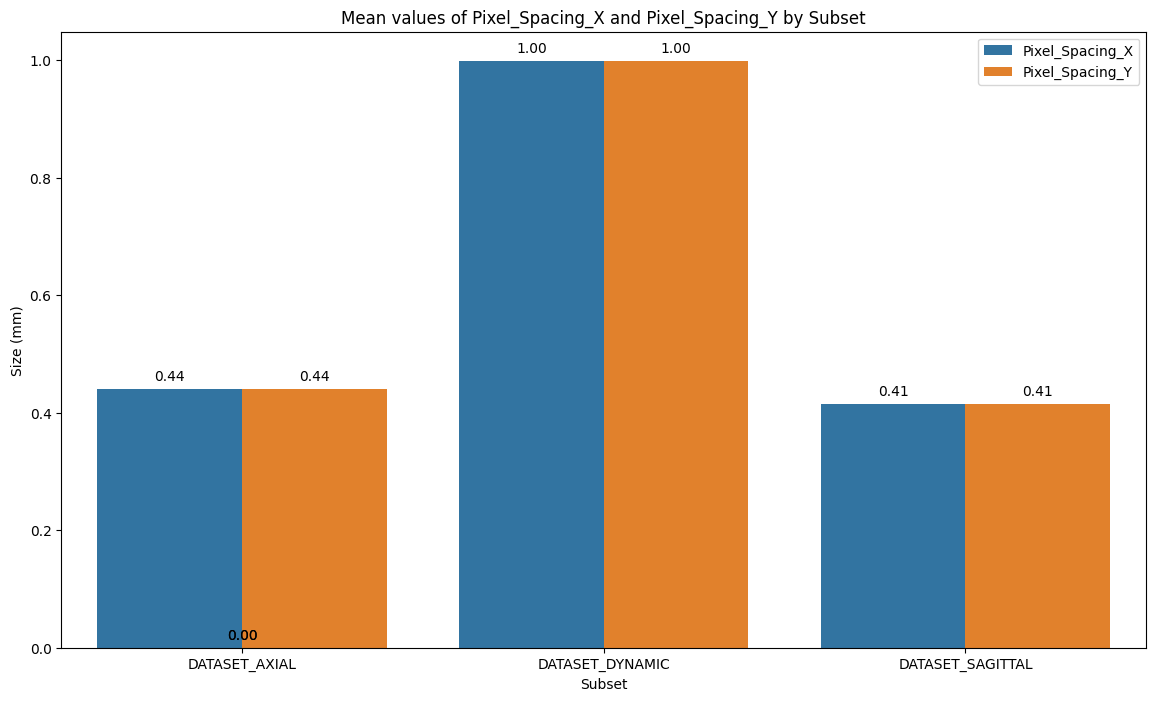

In [30]:
subset_mean_pixelSpacing = metadata_df.groupby('Subset')[['Pixel_Spacing_X','Pixel_Spacing_Y']].mean().reset_index()
plt.figure(figsize=(14, 8))

# id_vars argument specifies the column we want to keep 
# 
ax = sns.barplot(data=subset_mean_pixelSpacing.melt(id_vars='Subset', value_vars=['Pixel_Spacing_X', 'Pixel_Spacing_Y']), 
            x='Subset', y='value', hue='variable')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')
plt.title('Mean values of Pixel_Spacing_X and Pixel_Spacing_Y by Subset')
plt.xlabel('Subset')
plt.ylabel('Size (mm)')
plt.legend()
plt.show()

### Dividing the dataframe into 3 different df and respective csv

Old

In [6]:
axial_subset_data = metadata_df2[metadata_df2['Subset'] == 'DATASET_AXIAL']
sagittal_subset_data = metadata_df2[metadata_df2['Subset'] == 'DATASET_SAGITTAL']
dynamic_subset_data = metadata_df2[metadata_df2['Subset'] == 'DATASET_DYNAMIC']

Validated 

In [34]:
axial_subset_data_validated = metadata_df[metadata_df['Subset'] == 'DATASET_AXIAL']
sagittal_subset_data_validated = metadata_df[metadata_df['Subset'] == 'DATASET_SAGITTAL']
dynamic_subset_data_validated = metadata_df[metadata_df['Subset'] == 'DATASET_DYNAMIC']

Storing into csv - JUST TO STORE

Old

In [7]:
# store into the csv
axial_subset_data.to_csv('data/axial_subset_metadata.csv',index=False)
sagittal_subset_data.to_csv('data/sagittal_subset_metadata.csv',index=False)
dynamic_subset_data.to_csv('data/dynamic_subset_metadata.csv',index=False)

Validated

In [35]:
axial_subset_data_validated.to_csv('data/after_validation_pixelData/axial_subset_metadata_validated.csv',index=False)
sagittal_subset_data_validated.to_csv('data/after_validation_pixelData/sagittal_subset_metadata_validated.csv',index=False)
dynamic_subset_data_validated.to_csv('data/after_validation_pixelData/dynamic_subset_metadata_validated.csv',index=False)

### Load of 3 subsets TO DO 

In [36]:
axial_subset_data = pd.read_csv('data/after_validation_pixelData/axial_subset_metadata_validated.csv')
sagittal_subset_data = pd.read_csv('data/after_validation_pixelData/sagittal_subset_metadata_validated.csv')
dynamic_subset_data = pd.read_csv('data/after_validation_pixelData/dynamic_subset_metadata_validated.csv')

## Axial Distribution


The mean or median of the 'Slice Thickness' and 'Spacing between Slices' could be used as the representative metric for resampling. Given the peak around 3.0 for slice thickness and around 3.7 for spacing between slices, these could be our target resampling values.

The distribution of 'Number of Slices' is more varied. For resampling, this isn't a primary concern, but for creating volumes for the network, you might want to choose a standard depth. This could be done by either truncating longer sequences or padding shorter ones. The peak around 30 slices might serve as a good reference.

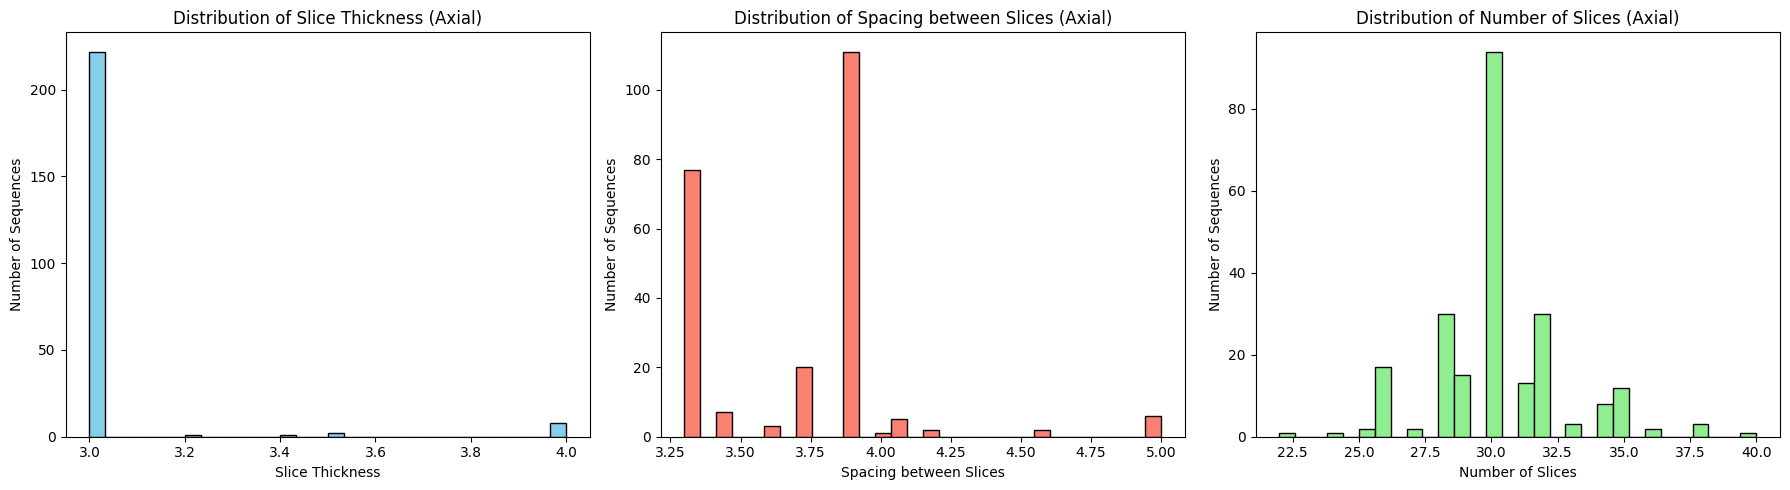

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# SliceThickness
ax[0].hist(axial_subset_data['Slice_Thickness'].dropna(), bins=30, color='skyblue', edgecolor='black')
ax[0].set_title('Distribution of Slice Thickness (Axial)')
ax[0].set_xlabel('Slice Thickness')
ax[0].set_ylabel('Number of Sequences')

# Spacing_between_Slices
ax[1].hist(axial_subset_data['Spacing_between_Slices'].dropna(), bins=30, color='salmon', edgecolor='black')
ax[1].set_title('Distribution of Spacing between Slices (Axial)')
ax[1].set_xlabel('Spacing between Slices')
ax[1].set_ylabel('Number of Sequences')

# Num_Slices
ax[2].hist(axial_subset_data['Num_Slices'].dropna(), bins=30, color='lightgreen', edgecolor='black')
ax[2].set_title('Distribution of Number of Slices (Axial)')
ax[2].set_xlabel('Number of Slices')
ax[2].set_ylabel('Number of Sequences')

plt.tight_layout()
plt.show()

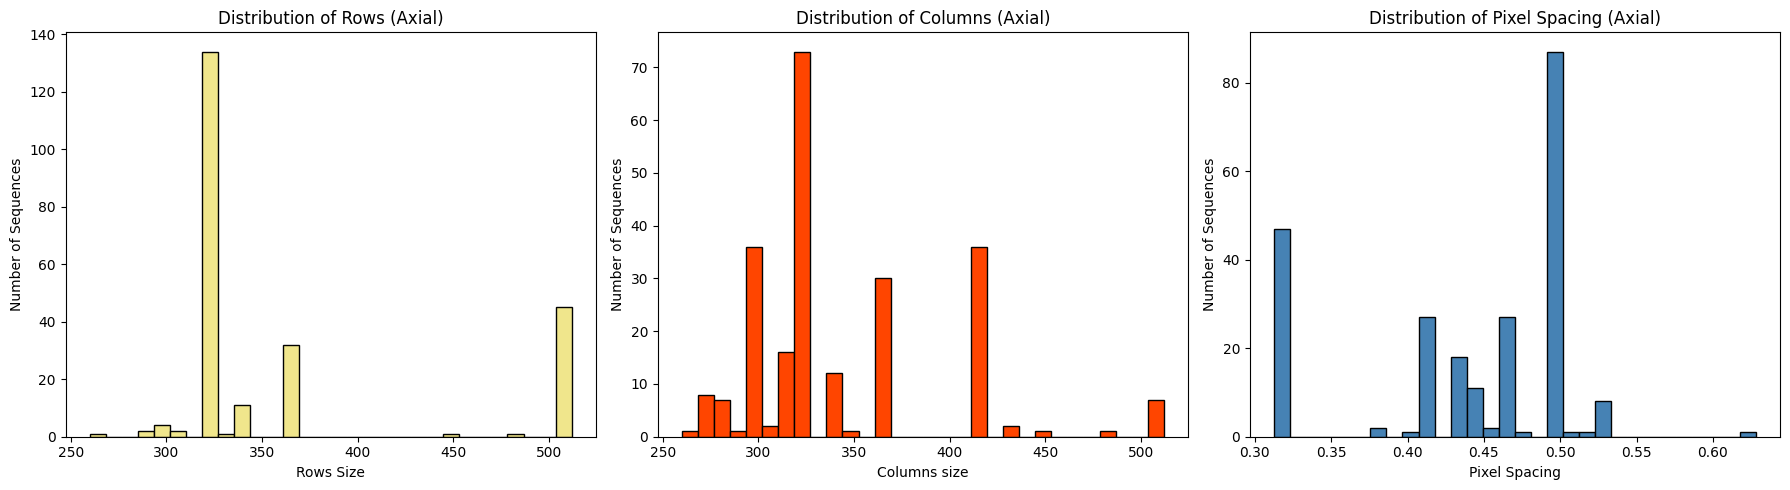

In [40]:
fig2, ax2 = plt.subplots(1, 3, figsize=(18, 5))

# SliceThickness
ax2[0].hist(axial_subset_data['Rows'].dropna(), bins=30, color='khaki', edgecolor='black')
ax2[0].set_title('Distribution of Rows (Axial)')
ax2[0].set_xlabel('Rows Size')
ax2[0].set_ylabel('Number of Sequences')

# Spacing_between_Slices
ax2[1].hist(axial_subset_data['Columns'].dropna(), bins=30, color='orangered', edgecolor='black')
ax2[1].set_title('Distribution of Columns (Axial)')
ax2[1].set_xlabel('Columns size')
ax2[1].set_ylabel('Number of Sequences')

# Num_Slices
ax2[2].hist(axial_subset_data['Pixel_Spacing_X'].dropna(), bins=30, color='steelblue', edgecolor='black')
ax2[2].set_title('Distribution of Pixel Spacing (Axial)')
ax2[2].set_xlabel('Pixel Spacing')
ax2[2].set_ylabel('Number of Sequences')

plt.tight_layout()
plt.show()

## Sagittal Distribution


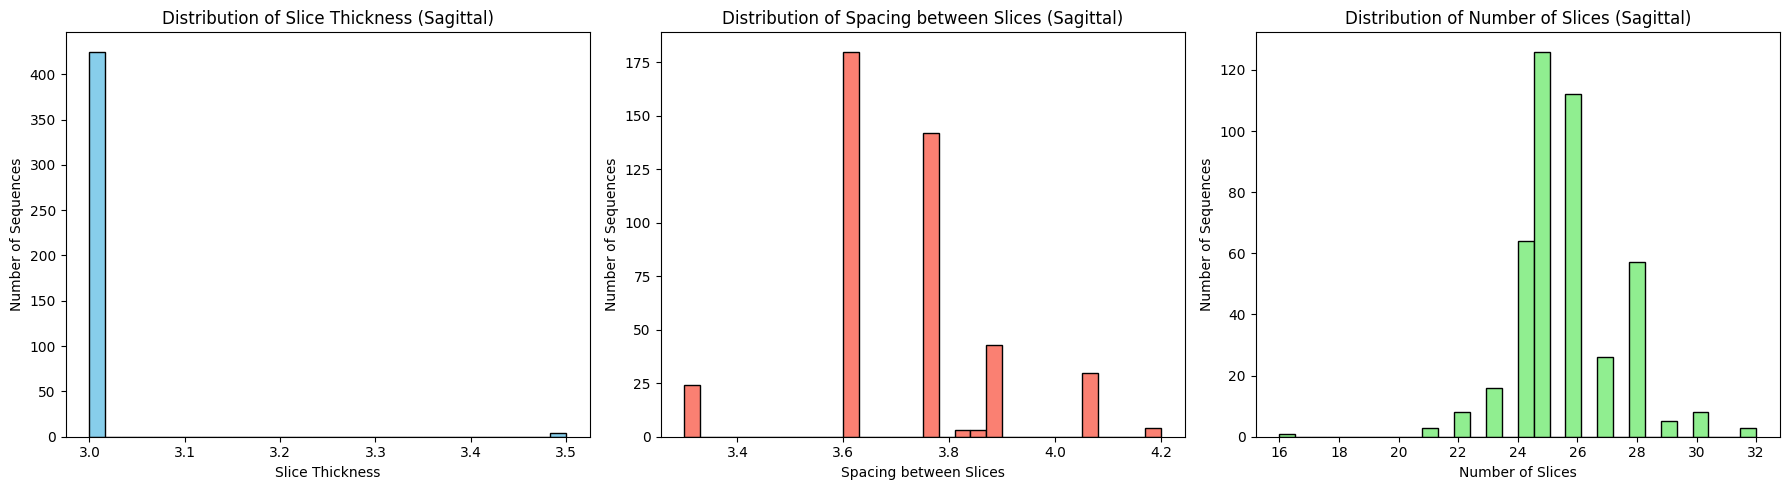

In [39]:
fig, sx = plt.subplots(1, 3, figsize=(18, 5))

# SliceThickness
sx[0].hist(sagittal_subset_data['Slice_Thickness'].dropna(), bins=30, color='skyblue', edgecolor='black')
sx[0].set_title('Distribution of Slice Thickness (Sagittal)')
sx[0].set_xlabel('Slice Thickness')
sx[0].set_ylabel('Number of Sequences')

# Spacing_between_Slices
sx[1].hist(sagittal_subset_data['Spacing_between_Slices'].dropna(), bins=30, color='salmon', edgecolor='black')
sx[1].set_title('Distribution of Spacing between Slices (Sagittal)')
sx[1].set_xlabel('Spacing between Slices')
sx[1].set_ylabel('Number of Sequences')

# Num_Slices
sx[2].hist(sagittal_subset_data['Num_Slices'].dropna(), bins=30, color='lightgreen', edgecolor='black')
sx[2].set_title('Distribution of Number of Slices (Sagittal)')
sx[2].set_xlabel('Number of Slices')
sx[2].set_ylabel('Number of Sequences')

plt.tight_layout()
plt.show()

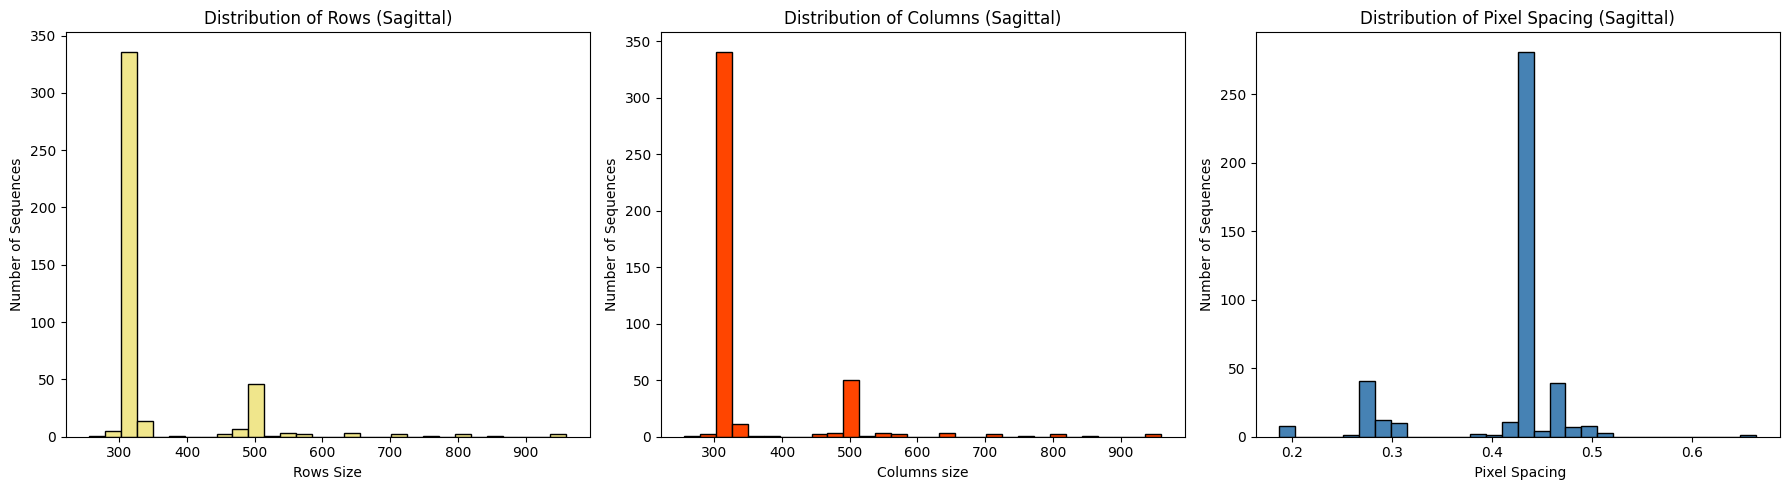

In [41]:
fig2, sx2 = plt.subplots(1, 3, figsize=(18, 5))

# SliceThickness
sx2[0].hist(sagittal_subset_data['Rows'].dropna(), bins=30, color='khaki', edgecolor='black')
sx2[0].set_title('Distribution of Rows (Sagittal)')
sx2[0].set_xlabel('Rows Size')
sx2[0].set_ylabel('Number of Sequences')

# Spacing_between_Slices
sx2[1].hist(sagittal_subset_data['Columns'].dropna(), bins=30, color='orangered', edgecolor='black')
sx2[1].set_title('Distribution of Columns (Sagittal)')
sx2[1].set_xlabel('Columns size')
sx2[1].set_ylabel('Number of Sequences')

# Num_Slices
sx2[2].hist(sagittal_subset_data['Pixel_Spacing_X'].dropna(), bins=30, color='steelblue', edgecolor='black')
sx2[2].set_title('Distribution of Pixel Spacing (Sagittal)')
sx2[2].set_xlabel(' Pixel Spacing')
sx2[2].set_ylabel('Number of Sequences')

plt.tight_layout()
plt.show()

## Dynamic Distribution

Atenção que nesta distribuição temos bastantes valores 'Nan', not a number

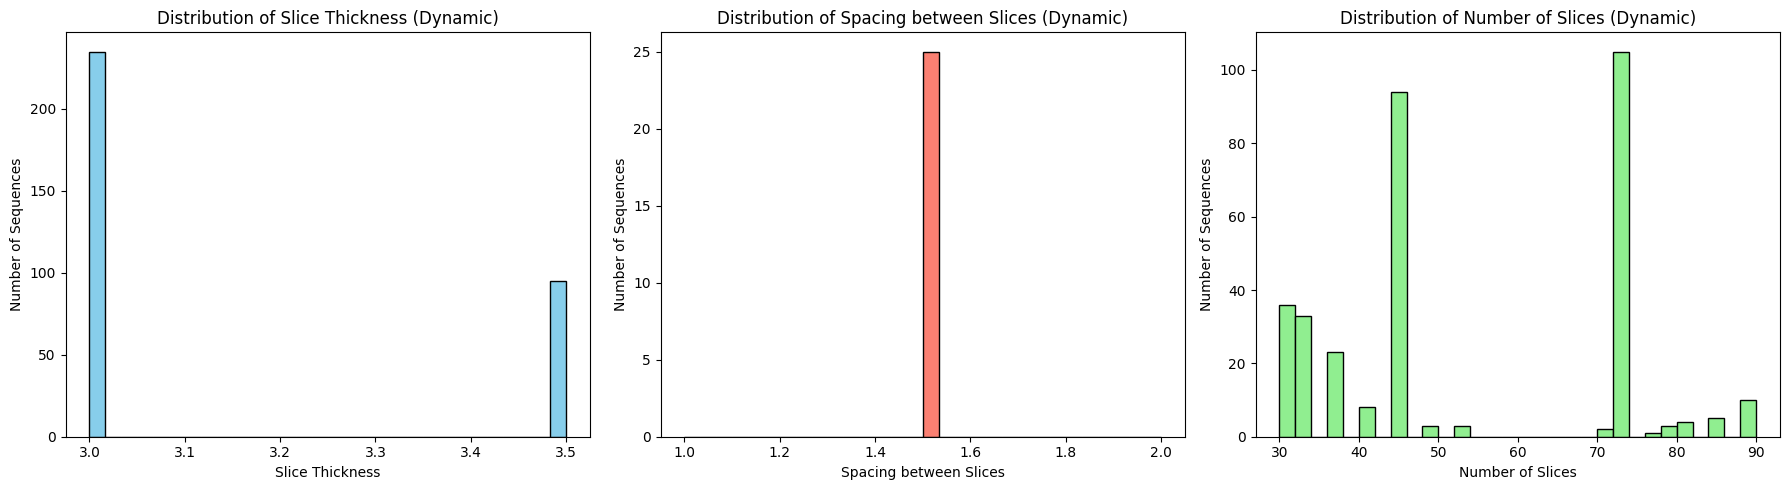

In [38]:
fig, dx = plt.subplots(1, 3, figsize=(18, 5))

# SliceThickness
dx[0].hist(dynamic_subset_data['Slice_Thickness'].dropna(), bins=30, color='skyblue', edgecolor='black')
dx[0].set_title('Distribution of Slice Thickness (Dynamic)')
dx[0].set_xlabel('Slice Thickness')
dx[0].set_ylabel('Number of Sequences')

# Spacing_between_Slices
dx[1].hist(dynamic_subset_data['Spacing_between_Slices'].dropna(), bins=30, color='salmon', edgecolor='black')
dx[1].set_title('Distribution of Spacing between Slices (Dynamic)')
dx[1].set_xlabel('Spacing between Slices')
dx[1].set_ylabel('Number of Sequences')

# Num_Slices
dx[2].hist(dynamic_subset_data['Num_Slices'].dropna(), bins=30, color='lightgreen', edgecolor='black')
dx[2].set_title('Distribution of Number of Slices (Dynamic)')
dx[2].set_xlabel('Number of Slices')
dx[2].set_ylabel('Number of Sequences')

plt.tight_layout()
plt.show()

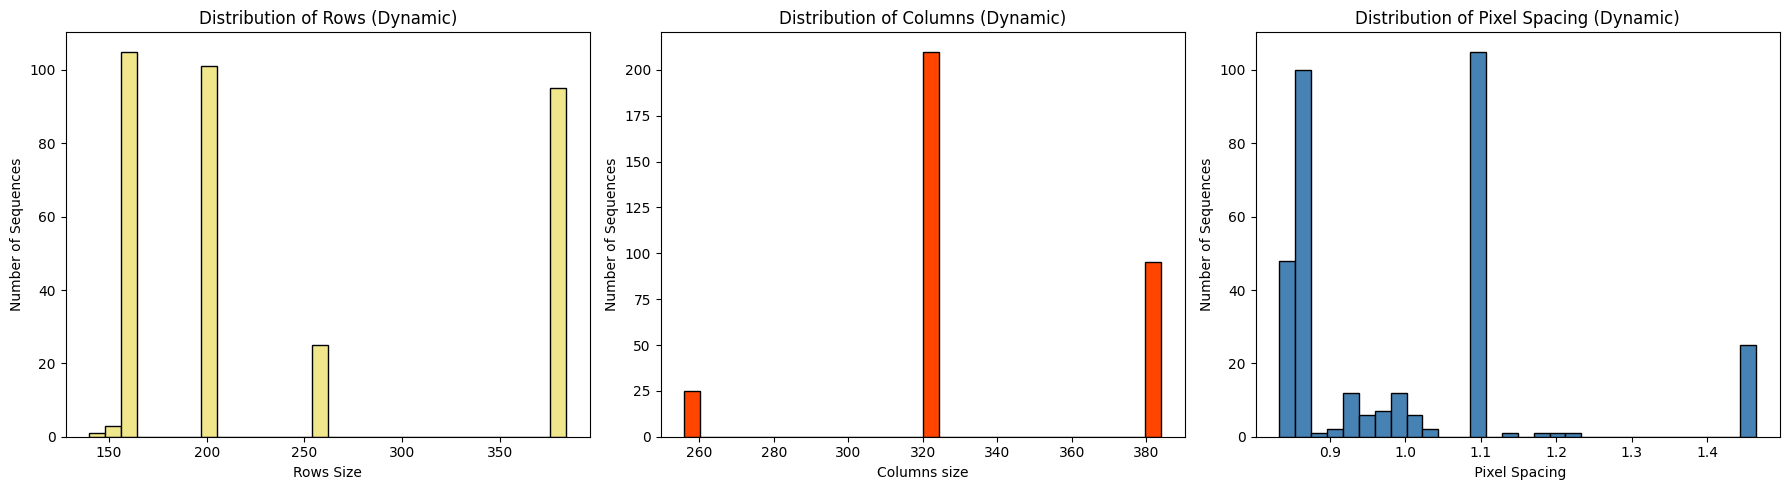

In [42]:
fig2, dx2 = plt.subplots(1, 3, figsize=(18, 5))

# SliceThickness
dx2[0].hist(dynamic_subset_data['Rows'].dropna(), bins=30, color='khaki', edgecolor='black')
dx2[0].set_title('Distribution of Rows (Dynamic)')
dx2[0].set_xlabel('Rows Size')
dx2[0].set_ylabel('Number of Sequences')

# Spacing_between_Slices
dx2[1].hist(dynamic_subset_data['Columns'].dropna(), bins=30, color='orangered', edgecolor='black')
dx2[1].set_title('Distribution of Columns (Dynamic)')
dx2[1].set_xlabel('Columns size')
dx2[1].set_ylabel('Number of Sequences')

# Num_Slices
dx2[2].hist(dynamic_subset_data['Pixel_Spacing_X'].dropna(), bins=30, color='steelblue', edgecolor='black')
dx2[2].set_title('Distribution of Pixel Spacing (Dynamic)')
dx2[2].set_xlabel(' Pixel Spacing')
dx2[2].set_ylabel('Number of Sequences')

plt.tight_layout()
plt.show()

## Excel analysis:
- T1,T2 e PD analysis

In [8]:
axial_excel_df = pd.read_excel(excel_paths[0])
dynamic_excel_df = pd.read_excel(excel_paths[1])
sagittal_excel_df = pd.read_excel(excel_paths[2])

### Axial subset

In [16]:
axial_excel_df.describe()

,Individual
count,234.000000
mean,42.452991
std,26.230571
min,1.000000
25%,18.000000
50%,43.000000
75%,63.750000
max,94.000000


In [9]:
t1_count_axial= axial_excel_df[axial_excel_df['Sequence'].str.contains('(?i)t1', regex=True)].shape[0]
t2_count_axial = axial_excel_df[axial_excel_df['Sequence'].str.contains('(?i)t2', regex=True)].shape[0]
pd_count_axial = axial_excel_df[axial_excel_df['Sequence'].str.contains('(?i)(pd|dp)', regex=True)].shape[0]

print(f"T1 sequences in axial: {t1_count_axial}")
print(f"T2 sequences in axial: {t2_count_axial}")
print(f"PD/DP sequences in axial: {pd_count_axial}")

T1 sequences in axial: 83
T2 sequences in axial: 0
PD/DP sequences in axial: 151


C:\Users\USER\AppData\Local\Temp\ipykernel_6560\1460199445.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  pd_count_axial = axial_excel_df[axial_excel_df['Sequence'].str.contains('(?i)(pd|dp)', regex=True)].shape[0]


### Dynamic subset

In [37]:
dynamic_excel_df.head()

,Dataset,Individual,Knee,Sequence,Landmarks
0,DATASET_DYNAMIC,1,LEFT,t1_vibe_tra_ext_com_contracao_18,"[(79.29096517544284, 112.51915670307669, 1, 24..."
1,DATASET_DYNAMIC,1,LEFT,t1_vibe_tra_ext_sem_contracao_16,"[(76.28889904252182, 107.31429558467234, 1, 25..."
2,DATASET_DYNAMIC,1,LEFT,t1_vibe_tra_flex_com_contracao_22,"[(74.89818426328824, 114.26786948084043, 1, 28..."
3,DATASET_DYNAMIC,1,LEFT,t1_vibe_tra_flex_sem_contracao_21,"[(67.94461036712016, 99.43357850234851, 1, 29)..."
4,DATASET_DYNAMIC,3,LEFT,t1_vibe_tra_ext_com_contracao_12,"[(76.75247063559972, 103.60572284004938, 1, 28..."


In [17]:
dynamic_excel_df.describe()

,Individual
count,330.000000
mean,41.642424
std,24.490418
min,1.000000
25%,21.000000
50%,40.000000
75%,63.000000
max,85.000000


In [43]:
t1_count_dynamic = dynamic_excel_df[dynamic_excel_df['Sequence'].str.contains('(?i)(t1|eTHRIVE)', regex=True)].shape[0]
t2_count_dynamic = dynamic_excel_df[dynamic_excel_df['Sequence'].str.contains('(?i)t2', regex=True)].shape[0]
pd_count_dynamic = dynamic_excel_df[dynamic_excel_df['Sequence'].str.contains('(?i)(pd|dp)', regex=True)].shape[0]

print(f"T1 sequences in dynamic: {t1_count_dynamic}")
print(f"T2 sequences in dynamic: {t2_count_dynamic}")
print(f"PD/DP sequences in dynamic: {pd_count_dynamic}")

T1 sequences in axial: 330
T2 sequences in axial: 0
PD/DP sequences in axial: 0


C:\Users\USER\AppData\Local\Temp\ipykernel_22716\931396410.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  t1_count_dynamic = dynamic_excel_df[dynamic_excel_df['Sequence'].str.contains('(?i)(t1|eTHRIVE)', regex=True)].shape[0]
C:\Users\USER\AppData\Local\Temp\ipykernel_22716\931396410.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  pd_count_dynamic = dynamic_excel_df[dynamic_excel_df['Sequence'].str.contains('(?i)(pd|dp)', regex=True)].shape[0]


### Sagittal subset

In [18]:
sagittal_excel_df.describe()

,Individual
count,429.000000
mean,42.251748
std,25.394863
min,1.000000
25%,20.000000
50%,42.000000
75%,62.000000
max,91.000000


In [19]:
t1_count_sagittal = sagittal_excel_df[sagittal_excel_df['Sequence'].str.contains('(?i)(t1|eTHRIVE)', regex=True)].shape[0]
t2_count_sagittal = sagittal_excel_df[sagittal_excel_df['Sequence'].str.contains('(?i)t2', regex=True)].shape[0]
pd_count_sagittal = sagittal_excel_df[sagittal_excel_df['Sequence'].str.contains('(?i)(pd|dp)', regex=True)].shape[0]

print(f"T1 sequences in sagittal: {t1_count_sagittal}")
print(f"T2 sequences in sagittal: {t2_count_sagittal}")
print(f"PD/DP sequences in sagittal: {pd_count_sagittal}")

T1 sequences in axial: 140
T2 sequences in axial: 134
PD/DP sequences in axial: 146


C:\Users\USER\AppData\Local\Temp\ipykernel_16316\2389682274.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  t1_count_sagittal = sagittal_excel_df[sagittal_excel_df['Sequence'].str.contains('(?i)(t1|eTHRIVE)', regex=True)].shape[0]
C:\Users\USER\AppData\Local\Temp\ipykernel_16316\2389682274.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  pd_count_sagittal = sagittal_excel_df[sagittal_excel_df['Sequence'].str.contains('(?i)(pd|dp)', regex=True)].shape[0]


### Total for each weighted-type images on the full dataset

In [46]:
print(f"Total T1 sequences: {t1_count_sagittal + t1_count_axial + t1_count_dynamic}")
print(f"Total T2 sequences: {t2_count_sagittal + t2_count_axial + t2_count_dynamic}")
print(f"Total PD/DP sequences: {pd_count_sagittal+ pd_count_axial + pd_count_dynamic}")

total T1 sequences: 553
total T2 sequences: 134
total PD/DP sequences: 297


### There are 9 sequences on the sagittal type that do not have the weight type associated

In [28]:
non_matching_sequences_count = sagittal_excel_df[
    ~sagittal_excel_df['Sequence'].str.contains('(?i)(t1|eTHRIVE|t2|pd|dp)', regex=True)
]

C:\Users\USER\AppData\Local\Temp\ipykernel_16316\737073904.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ~sagittal_excel_df['Sequence'].str.contains('(?i)(t1|eTHRIVE|t2|pd|dp)', regex=True)


In [22]:
print(non_matching_sequences_count)

              Dataset  Individual   Knee         Sequence  \
148  DATASET_SAGITTAL          28   LEFT    sFFE_SAG_1602   
152  DATASET_SAGITTAL          29   LEFT     sFFE_SAG_502   
154  DATASET_SAGITTAL          29  RIGHT     sFFE_SAG_602   
157  DATASET_SAGITTAL          30   LEFT     sFFE_SAG_502   
160  DATASET_SAGITTAL          31  RIGHT    sFFE_SAG_1202   
163  DATASET_SAGITTAL          32   LEFT    sFFE_SAG_1602   
249  DATASET_SAGITTAL          48   LEFT  SAGITAL_STIR_11   
386  DATASET_SAGITTAL          80  RIGHT     sFFE_SAG_702   
391  DATASET_SAGITTAL          81  RIGHT     sFFE_SAG_602   

                                             Landmarks  
148  [(125.29961518276272, 179.6871129834846, 1, 10...  
152  [(103.12974280027566, 55.34849737991762, 1, 13...  
154  [(111.91116087753065, 48.63329532084035, 1, 9)...  
157  [(170.8598227645192, 170.57507146713334, 1, 10...  
160  [(116.08110361270342, 133.4395828071693, 1, 13...  
163  [(136.6263890121162, 104.67096563880088, 1

## Conclusions
- Slice Thickness: actual thickness of the slice captured in the MRI, representing the z-dimension 'width' of each individual slice
- Spacing between Slices: representing the distance between the centers of two consecutive slices If slices have no gap or overlap, then spacing between slices will be the same as the slice thickness. However, in some cases, slices might slightly overlap or have a gap, leading to different values for slice thickness and spacing between slices. 
- Number of slices: total count of slices in the volume, and along with the slice thickness, can determine the total depth of the original volume.


What tags/properties should be considered for dataset resampling